In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
validation_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

X_train,y_train = train_df[['text','length','words']],train_df['spam']
X_test,y_test = test_df[['text','length','words']],test_df['spam']
X_val,y_val = validation_df[['text','length','words']],validation_df['spam']

# Impute or remove NaN values in the 'text' column
X_train = X_train.dropna(subset=['text'])
y_train = y_train[X_train.index]  # Update y_train to match X_train index
X_test = X_test.dropna(subset=['text'])
y_test = y_test[X_test.index]
X_val = X_val.dropna(subset=['text'])
y_val = y_val[X_val.index]


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np

tfidf_vectorizer = TfidfVectorizer(max_features=3000)
tfidf_features = tfidf_vectorizer.fit_transform(X_train['text']).toarray()

scaler = StandardScaler()
length_words_scaled = scaler.fit_transform(X_train[['length', 'words']])

X_train = np.hstack((tfidf_features, length_words_scaled))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Doing the same with validation and test data
tfidf_features_test = tfidf_vectorizer.transform(X_test['text']).toarray()
length_words_scaled_test = scaler.transform(X_test[['length', 'words']])
X_test = np.hstack((tfidf_features_test, length_words_scaled_test))

tfidf_features_val = tfidf_vectorizer.transform(X_val['text']).toarray()
length_words_scaled_val = scaler.transform(X_val[['length', 'words']])
X_val = np.hstack((tfidf_features_val, length_words_scaled_val))

## Training models

Training Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic Regression Validation F1 Score: 0.9364548494983278
Logistic Regression Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       961
           1       0.96      0.92      0.94       153

    accuracy                           0.98      1114
   macro avg       0.97      0.95      0.96      1114
weighted avg       0.98      0.98      0.98      1114



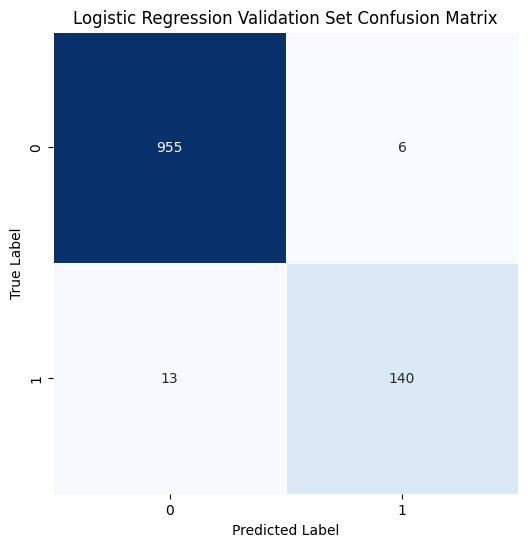

Training Decision Tree...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Decision Tree Validation F1 Score: 0.8176100628930818
Decision Tree Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       961
           1       0.79      0.85      0.82       153

    accuracy                           0.95      1114
   macro avg       0.88      0.91      0.89      1114
weighted avg       0.95      0.95      0.95      1114



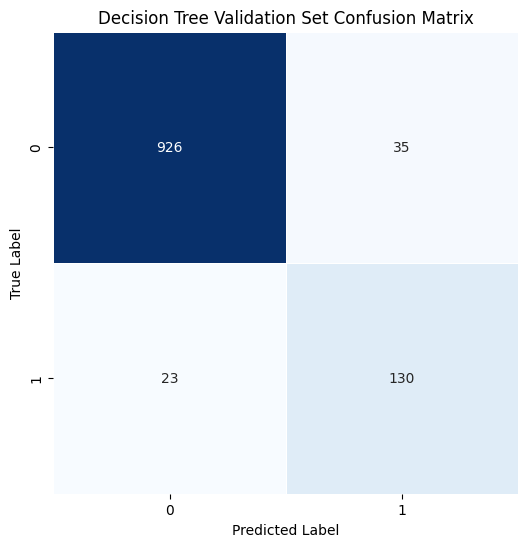

Training Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest Validation F1 Score: 0.9084507042253521
Random Forest Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       961
           1       0.98      0.84      0.91       153

    accuracy                           0.98      1114
   macro avg       0.98      0.92      0.95      1114
weighted avg       0.98      0.98      0.98      1114



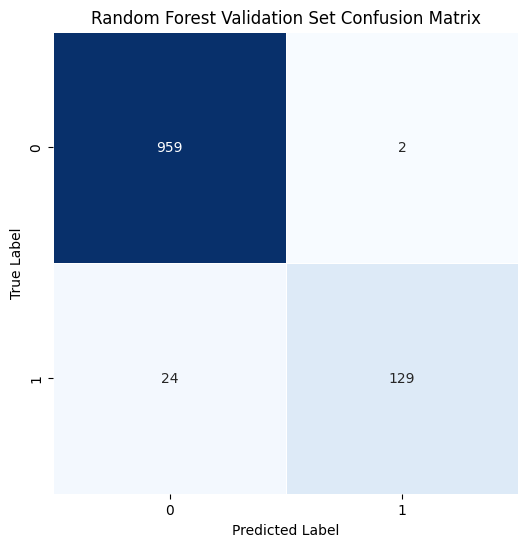

Training SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
SVM Validation F1 Score: 0.9351535836177475
SVM Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       961
           1       0.98      0.90      0.94       153

    accuracy                           0.98      1114
   macro avg       0.98      0.95      0.96      1114
weighted avg       0.98      0.98      0.98      1114



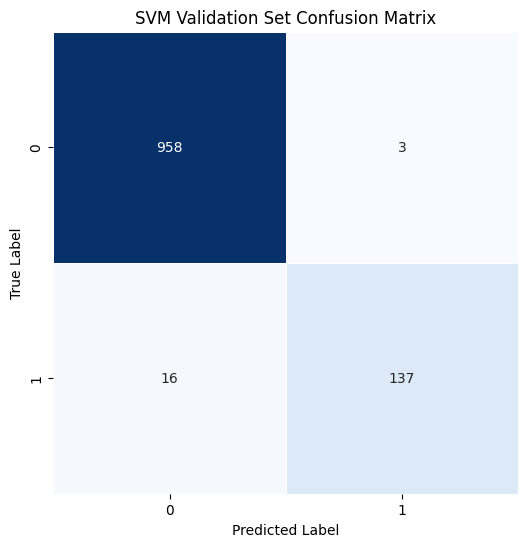

Best Model Test F1 Score: 0.9591836734693877
Best Model Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.97      0.95      0.96       149

    accuracy                           0.99      1114
   macro avg       0.98      0.97      0.98      1114
weighted avg       0.99      0.99      0.99      1114



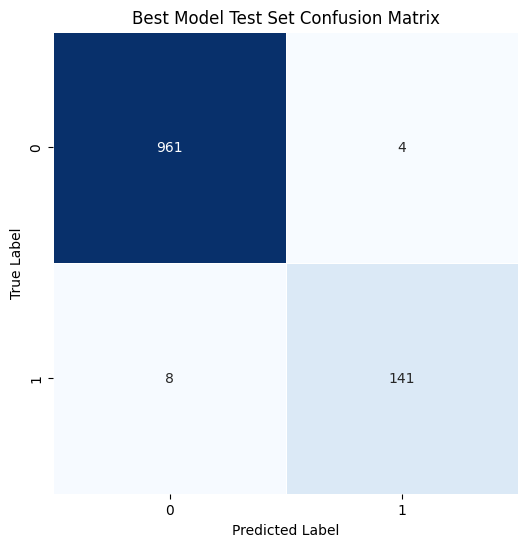

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix,ConfusionMatrixDisplay, classification_report # Added classification_report here
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_my_confusion_matrix(y_true, y_pred, title):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues", cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()



models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20]},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]}
}

best_f1 = 0
best_model = None


for model_name, model in models.items():
    print(f"Training {model_name}...")

    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_smote, y_train_smote)

    y_val_pred = grid_search.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred)
    report_val = classification_report(y_val, y_val_pred)

    print(f"{model_name} Validation F1 Score: {f1_val}")
    print(f"{model_name} Validation Set Classification Report:\n {report_val}")
    plot_my_confusion_matrix(y_val, y_val_pred, f"{model_name} Validation Set Confusion Matrix")

    if f1_val > best_f1:
        best_f1 = f1_val
        best_model = grid_search


y_test_pred = best_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred)

print("Best Model Test F1 Score:", f1_test)
print("Best Model Test Set Classification Report:\n", report_test)
plot_my_confusion_matrix(y_test, y_test_pred, "Best Model Test Set Confusion Matrix")